## TUTORIAL 03 - Geometrical parametrization
**_Keywords: geometrical parametrization_**

### 1. Introduction

This Tutorial introduces problems featuring a geometrical parametrization, by solving a thermal conduction problem on a parametrized computational domain $\Omega_o(\boldsymbol{\mu})$ shown below:

<img src="data/hole_1.png" width="35%"/>

The problem is characterized by three parameters. The parameters $\mu_0$ and $\mu_1$ are related to the shape of the central hole as shown in the picture above, and vary in the following intervals
$$
\mu_0\in[0.5,1.5] \quad \text{and}\quad \mu_1\in[0.5,1.5].
$$

The parameter $\mu_2$ is the Biot number, which allows to parametrize heat exchange with a surrounding exterior fluid (e.g., air) in the following interval
$$
\mu_2\in[0.01,1];
$$
the diffusion process on the external boundaries $\Gamma_{o, 5} \cup \Gamma_{o, 6} \cup \Gamma_{o, 7} \cup \Gamma_{o, 8}$ will be affected by this parameter.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \mu_1, \mu_2)
$$
on the parameter domain
$$
\mathbb{P}=[0.5,1.5]^2\times[0.01,1].
$$

In order to obtain a faster approximation of the problem, and avoiding _any_ remeshing, we pursue a model reduction by means of a POD-Galerkin reduced order method from a fixed reference domain.

### 2. Parametrized formulation

Let $u_o(\boldsymbol{\mu})$ be the temperature in the domain $\Omega_o(\boldsymbol{\mu})$.

We will directly provide a weak formulation for this problem
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u_o(\boldsymbol{\mu})\in\mathbb{V}_o(\boldsymbol{\mu})$ such that</center>

$$a_o\left(u_o(\boldsymbol{\mu}),v_o;\boldsymbol{\mu}\right)=f_o(v_o;\boldsymbol{\mu})\quad \forall v_o\in\mathbb{V}_o(\boldsymbol{\mu})$$

where

* the function space $\mathbb{V}_o(\boldsymbol{\mu})$ is defined as
$$
\mathbb{V}_o(\boldsymbol{\mu}) = H^1(\Omega(\boldsymbol{\mu})).
$$
Note that, in contrast to the previous tutorials, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \times \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$a_o(u_o,v_o;\boldsymbol{\mu}) = \int_{\Omega_o(\boldsymbol{\mu})}\nabla u_o\cdot\nabla v_o \ d\boldsymbol{x} + \mu_2\left(\int_{\Gamma_{o,5}}u_o\,v_o \ ds + \int_{\Gamma_{o,6}}u_o\,v_o \ ds + \int_{\Gamma_{o,7}}u_o\,v_o \ ds + \int_{\Gamma_{o,8}}u_o\,v_o \ ds\right),$$
* the parametrized linear form $f_o(\cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$f_o(v_o;\boldsymbol{\mu}) = \int_{\Gamma_{o,1}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,2}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,3}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,4}(\boldsymbol{\mu})}v_o \ ds.$$

In [1]:
import sys
sys.path.append("../../MLniCS/")
from mlnics import NN, Normalization, Losses
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

In order to obtain an affine decomposition, we need to recast the problem on a fixed, parameter _independent_, reference domain, as follows:

1. Choose $\Omega = \Omega_o((\mu_0, \mu_1) \equiv (1, 1))$ as reference domain, which we generate through the generate_mesh notebook provided in the _data_ folder.
2. Define a map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu}): \Omega \to \Omega_o(\boldsymbol{\mu})$ to carry out a pull back of the problem from the parametrized domain $\Omega_o(\boldsymbol{\mu})$ to the reference one $\Omega$. Since we aim at obtaining an affine decomposition, the map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu})$ should be affine in its first argument. This is possible by taking a partition of the reference domain in several triangular subdomains, such as the following one

<img src="data/hole_2.png" width="35%"/><br>
3. Define a reference function space $$\mathbb{V} = H^1(\Omega),$$ to which the pulled back solution
$$u(\boldsymbol{\cdot}; \boldsymbol{\mu}) = u_o(\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu}); \boldsymbol{\mu})$$ belongs
4. Pull back the bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu})$ and linear form $f_o(\cdot; \boldsymbol{\mu})$ onto the reference domain $\Omega$ by change of variables. Note that, due to the definition of the map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu})$, the pull back will be different from one subdomain to the other. Call
$$a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$$
$$f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$$
the resulting forms (and note that their arguments are now defined on $\Omega$).
5. Solve the equivalent problem
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$


In [2]:
@PullBackFormsToReferenceDomain()
@AffineShapeParametrization("data/hole_vertices_mapping.vmp")
class Hole(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        self.subdomains = subdomains
        self.boundaries = boundaries

    # Return custom problem name
    def name(self):
        return "Hole"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.0
            theta_a1 = mu[2]
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = 1.0
            return (theta_f0, )
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        u = self.u
        v = self.v
        dx = self.dx
        ds = self.ds
        if term == "a":
            a0 = inner(grad(u), grad(v)) * dx
            a1 = inner(u, v) * ds(5) + inner(u, v) * ds(6) + inner(u, v) * ds(7) + inner(u, v) * ds(8)
            return (a0, a1)
        elif term == "f":
            f0 = v * ds(1) + v * ds(2) + v * ds(3) + v * ds(4)
            return (f0, )
        elif term == "inner_product":
            x0 = u * v * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/hole.xml")
subdomains = MeshFunction("size_t", mesh, "data/hole_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/hole_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Hole class

In [5]:
problem = Hole(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.5, 1.5), (0.5, 1.5), (0.01, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-6)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

=                    Hole POD-Galerkin offline phase begins                    =

###################################### 0 #######################################
truth solve for mu = (1.0488135039273248, 1.2151893663724196, 0.6067357423109274)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (1.0448831829968968, 0.9236547993389047, 0.6494351719359895)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (0.9375872112626925, 1.3917730007820799, 0.964026132896019)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (0.8834415188257777, 1.2917250380826646, 0.5336059705553754)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (1.0680445610939322, 1.425596638292661, 0.08032569761590806)
upda

truth solve for mu = (0.5191931983093335, 0.8015748166745493, 0.6635718021177582)
update snapshots matrix

###################################### 43 ######################################
truth solve for mu = (0.7900776072104441, 1.1180154289988415, 0.4344810139363085)
update snapshots matrix

###################################### 44 ######################################
truth solve for mu = (0.6354740642224502, 0.7982823259560308, 0.5742652615942522)
update snapshots matrix

###################################### 45 ######################################
truth solve for mu = (1.0908727612481732, 1.0743252488495787, 0.6566688116585623)
update snapshots matrix

###################################### 46 ######################################
truth solve for mu = (1.1521032700016889, 0.931418435433974, 0.8975811298925523)
update snapshots matrix

###################################### 47 ######################################
truth solve for mu = (0.8675618700478965, 0.9358649252656268,

truth solve for mu = (1.461936378547229, 0.7921475267925489, 0.24842049211629236)
update snapshots matrix

###################################### 87 ######################################
truth solve for mu = (0.6002939422654978, 0.5164296295914742, 0.9302340236242687)
update snapshots matrix

###################################### 88 ######################################
truth solve for mu = (1.16991654659091, 1.2851529120231378, 0.2889128046964096)
update snapshots matrix

###################################### 89 ######################################
truth solve for mu = (1.0864101661863268, 0.5639552661209811, 0.4907713199752767)
update snapshots matrix

###################################### 90 ######################################
truth solve for mu = (1.477495139744447, 1.376505245316591, 0.34477736231847717)
update snapshots matrix

###################################### 91 ######################################
truth solve for mu = (1.4615701545414985, 0.7317016264712045, 0

In [8]:
net = NN.RONN(problem, reduction_method)

reduction_method.initialize_testing_set(100)
test_mu, val_mu = NN.get_test_validation(net, validation_proportion=0.2)

In [9]:
input_normalization = Normalization.StandardNormalization()
output_normalization = Normalization.IdentityNormalization()

In [10]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [12]:
NN.normalize_and_train(net, pinn_loss, input_normalization, 
                       lr=0.001, epochs=10000, validation_set=val_mu)

0 9.073873225569708 	mean error(validation) = 0.99959474868899
100 0.5925783955423694 	mean error(validation) = 0.22426142426496995
200 0.3979195585143952 	mean error(validation) = 0.18024272052793897
300 0.26911430889078936 	mean error(validation) = 0.12987368289063195
400 0.19816448547576943 	mean error(validation) = 0.10304616738942127
500 0.16274780369415964 	mean error(validation) = 0.0912727192561043
600 0.14024832805057086 	mean error(validation) = 0.08429251714417904
700 0.12332672785617704 	mean error(validation) = 0.07727651179282277
800 0.10955838723738559 	mean error(validation) = 0.07068726039001096
900 0.09740044962736277 	mean error(validation) = 0.06462906241885048
1000 0.08702293434781769 	mean error(validation) = 0.059120740640591175
1100 0.0784122248151115 	mean error(validation) = 0.05421713133666141
1200 0.07039490769776453 	mean error(validation) = 0.049477320978950835
1300 0.063901565743607 	mean error(validation) = 0.045418642470151434
1400 0.05896191955143409 	

### 4.6. Perform an online solve

[-8.68876960e+01  1.17055892e+01 -1.63459071e+00  1.71439808e+00
  4.77099460e-01  3.38141569e-01  1.12079478e-01 -1.47588403e-01
  3.39818977e-02  3.76137272e-02  8.77197222e-03  4.44096817e-02]


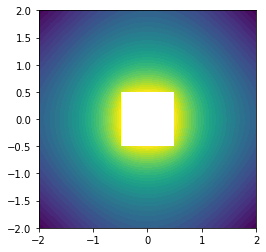

In [16]:
online_mu = (0.5, 0.5, 0.01)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
print(reduced_solution)
plot(reduced_solution, reduced_problem=reduced_problem)

[-3.94785461e+01  3.66968393e+00 -1.12151039e+00  1.11338723e+00
  2.27757931e-01  8.97631794e-03  2.26154011e-02 -5.01799248e-02
  3.63111831e-02  2.01111510e-02 -6.32158667e-03  5.81000224e-02]


RONN(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=12, bias=True)
  )
)

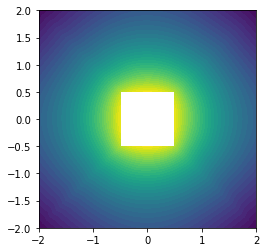

In [17]:
net.eval()

with torch.no_grad():
    online_mu_nn = torch.tensor(online_mu)
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization)
    print(reduced_solution_nn)
    plot(reduced_solution_nn, reduced_problem=reduced_problem)

net.train()

0.021686432354179684


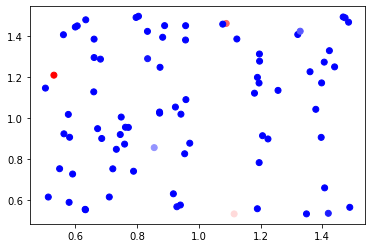

In [18]:
errors, error_plot = NN.plot_error(net, test_mu, input_normalization)
print(np.mean(errors))
error_plot

### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

### 4.8. Perform a speedup analysis

In [ ]:
# 8. Perform a speedup analysis
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()

## 5. Assignments
1. Why was the domain $\Omega$ partitioned into triangular subdomains, rather than e.g. rectangular ones? Pick a subdomain $\Omega_s$, $s=1, \dots, 8$ and write down the transformation $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu})|_{\Omega_s}$. Then, perform by yourself the change of variable to obtain the addends in $a(\cdot, \cdot; \boldsymbol{\mu})$ and $f(\cdot; \boldsymbol{\mu})$ corresponding to the subdomain $\Omega_s$. Finally, compare what you have obtained to the automatic pull back carried out by RBniCS enabling debugging in the Hole decorators as follows:
```
from utils.decorators import EnableDebug
@EnableDebug()
@PullBackFormsToReferenceDomain()
@AffineShapeParametrization("data/hole_vertices_mapping.vmp")
```

2. Consider an additional parameter $\mu_3 \in [-0.1, 0.1]$ and let now the position of the bottom right vertex of the rectangular hole be defined as $(\mu_0, -\mu_1 + \mu_3)$ instead of $(\mu_0, -\mu_1)$. The deformation of the remaining vertices is the same as the original problem. Edit the mappings defined in the generate_mesh notebook in the _data_ folder accordingly, as well as the Hole class in this notebook. Which triangular subdomains are affected by this change, and which aren't? _Suggestion: make sure also to change the mapping filename in the mesh generation notebook before saving it to file. Moreover, for every new notebook copy change the value returned by the name() method of the Hole class to avoid conflicts between this notebook and your copy_.

3. [*] Consider now a different shape variation which, starting from the reference domain $\Omega$, rotates the square hole of angle $\theta$. The resulting problem is characterized by two parameters, $\theta$ and $\mu_2$. Edit the mappings defined in the generate_mesh notebook in the _data_ folder accordingly, as well as the Hole class in this notebook. What should be the range of variation for $\theta$? Discuss the results in terms of errors and speedups.
